<center> <font size='6' font-weight='bold'> Model Part </font> </center>  
<center> <i> Projet Navee</i> </center>
<center> <i> Tony WU </i> </center>  
  
  
<img src=ressources/image_couverture.jpg>

**Objective:** This notebook seeks to implement some tools to easily create models, train and predict.

# Prelude

## Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
import io

# Tensorflow
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Hyperparameters
from tensorboard.plugins.hparams import api as hp

# Interactive
import ipywidgets as widgets
from ipywidgets import interact, interactive, IntSlider
from IPython.display import display

## Checking environment

### Jupyter vs Colab

For convenience, we'll make sure that this notebook can run both on *Jupyter Notebook* as well as on *Google Colab*.

**The following cell generates a boolean that indicates if you're running with Colab:**

In [2]:
try:
    import google.colab
    IN_COLAB = True
    print("Colab detected ✅")
except:
    IN_COLAB = False
    print("Colab not detected. ❌ Running on notebook 👩🏻‍💻")

Colab not detected. ❌ Running on notebook 👩🏻‍💻


If possible, please activate GPU for faster computation.  
If using Colab, you'll have to go to `Runtime`, `Change runtime type` then select `GPU` in `Hardware Accelerator`.

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found ❌')
else:
    print('Found GPU at: {} ✅'.format(device_name))

GPU device not found ❌


### Checking tensorflow version

In [4]:
print(tf.__version__)

'2.1.0'

Should be `2.1.0` or higher.

In [6]:
assert(int(tf.__version__[0]) >= 2), "You are using TensorFlow 1, please update before proceeding!"

# Tensorboard callback configuration

**Important :**
Run the following cell in order to load tensorboard seemlessly in the notebook!

In [5]:
%load_ext tensorboard

**If running in Colab, one shall check Tensorboard right here.**

In [6]:
if IN_COLAB:
    %tensorboard --logdir logs

**NB:** Sometimes, it might not be enough to just refresh the Tensorboard. In last resort, please rerun the previous cell.

We'll store all the logs in a directory named `logs`.  
In this folder, we'll have subfolders, each named according to what kind of data it stores. For instance, the line below creates a callback that is going to store scalars values (such as accuracy and loss with respect to epochs).

‼️ **Global variables, may be required for the following functions:** ‼️
- `logdir_scalars`: the path to the directory containing the scalar logs
- `tensorboard_callback`: the basic callback that stores scalar data

In [7]:
logdir_scalars = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir_scalars)

**If not in Colab**, run `tensorboard --logdir logs` in Terminal to launch Tensorboard.

# Loading dataset

The following cell will act only if in Colab.  
If that's the case, follow the instruction to allow Colab to access your GoogleDrive.

In [8]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',  force_remount=True)

In [9]:
if IN_COLAB:
    !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
    !unzip ngrok-stable-linux-amd64.zip

The following lines make sure the given directory exists.

In [10]:
print("Current directory:\n")
print(os.getcwd())

Current directory:

/Users/Tony/Desktop/projet-navee/model_Tony


In [12]:
data_path = '101_ObjectCategories'

assert os.path.isdir(data_path), 'Dataset not found 👎🏻'
print ('Dataset found 🤙🏻')

Dataset found 🤙🏻


The following lines make sure the given directory exists.

## Some useful functions

In [13]:
def get_data(data_path, img_size, batch_size, validation_split = 0.2, **kwargs):
    '''Given a directory containing all the images stored in folders named with the corresponding label,
    this function returns two data generators object.
    
    Inputs:
        - data_path = string
        - img_size = 2-tuple of the images' dimensions
        - batch_size = size of the batch (please input power of 2 for more efficiency)
        - validation_split = float between 0 and 1 that gives the percentage allocated to the validation set
        - **kwargs = optional dictionary which contains arguments for data augmentation
        
    Outputs:
        - ImageDataGenerator object
    '''
    
    datagen = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=preprocess_input,
                                 validation_split=validation_split,
                                 **kwargs)
    
    train_generator = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset = 'training')

    validation_generator = datagen.flow_from_directory(
        data_path,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical',
        subset = 'validation')
    
    return train_generator, validation_generator

In [14]:
def show_img(data_gen, batch_idx, idx):
    ''''Display the prompted image with MatPlotLib.
    
    Inputs:
        - data_gen = a generator returned by get_data for instance
        - imgbatch_idx = the index of the batch
        - idx = the index of the image inside the selected batch
        
    Outputs:
        - an ImageDataGenerator object
    '''
    
    
    plt.imshow(data_gen[batch_idx][0][idx])
    return 

In [15]:
def show_label(data_gen, batch_idx, idx):
    ''''Returns the label of the prompted image.
    
    Inputs:
        - data_gen = a generator returned by get_data for instance
        - imgbatch_idx = the index of the batch
        - idx = the index of the image inside the selected batch
        
    Outputs:
        - a string
    '''
    
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    
    return labels[np.argmax(data_gen[batch_idx][1][idx])]

In [16]:
def get_batch_size(image_generator):
    '''
    Returns the number of batches of a set contained in an ImageGenerator object.
    
    Input:
        - image_generator = ImageGenerator object
    Output:
        - len(train_generator) = number of batches
    '''
    return len(train_generator)

## Some examples

In [17]:
img_size = (120, 120)
batch_size = 32

In [18]:
train_generator, validation_generator = get_data(data_path, img_size, batch_size, validation_split = 0.2)

Found 7356 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.


In [19]:
nb_batches = get_batch_size(train_generator)
print(f'nb_batches = {nb_batches}')

nb_batches = 230


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'Leopards'

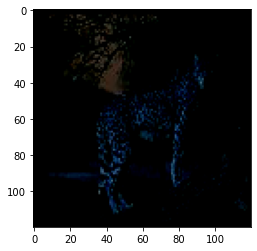

In [20]:
batch_idx = np.random.randint(0, nb_batches)
idx = np.random.randint(0, len(train_generator[0][0]))

show_img(train_generator, batch_idx, idx)
show_label(train_generator, batch_idx, idx)

In [21]:
def explore_train_generator(data_gen_idx, batch_idx, idx):
    data_gen = train_generator if data_gen_idx == 0 else validation_generator
    show_label(data_gen, batch_idx, idx)
    show_img(data_gen, batch_idx, idx)
    return

data_gen_idx_widget = widgets.Dropdown(
    options=[('train_generator', 0), ('validation_generator', 1)],
    value=1,
    description='data_gen',
)

batch_idx_widget = IntSlider(min=0, max=10, step=1, continuous_update=False)
idx_widget = IntSlider(min=0, max=100, step=1, continuous_update=False)

def update_widgets(*args):
    if data_gen_idx_widget.value == 0:
        batch_idx_widget.max = len(train_generator)
        idx_widget.max = len(train_generator[0][0]) - 1
    else:
        batch_idx_widget.max = len(validation_generator)
        idx_widget.max = len(validation_generator[0][0]) - 1
batch_idx_widget.observe(update_widgets, 'value')
idx_widget.observe(update_widgets, 'value')

interact(explore_train_generator,
         data_gen_idx = data_gen_idx_widget,
         batch_idx=batch_idx_widget,
         idx=idx_widget);

interactive(children=(Dropdown(description='data_gen', index=1, options=(('train_generator', 0), ('validation_…

# Creating the model

## Some utilities first

We'll start from Matheus's empirical model which is the following:
```python
model = Sequential()
model.add(ResNet50(include_top = False,weights = 'imagenet'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dense(102,activation='softmax'))
```

However, we choose instead to give to `generate_model` a `hparams` argument so much so that it'll be much easier to buid the hyperparameter tuning function and we won't have to hardcode those into the `generate_model` function.  
Moreover, all the following functions automatically log their data in *Tensorboard*.

In [22]:
def generate_model(hparams):
    '''
    A function that generates the model based on the hyperparameters that are given.
    The model is not yet compiled, neither with the weights

    Inputs:
        - hparams: a dictionnary containning, at least, the following hyperparameters (in parenthesis is the hyperparameter key)
          - 'HP_DROPOUT': value for dropout'
          - 'HP_NUM_UNITS_RELU': number of units in the second to last (Dense) layer
          - 'HP_NB_FROZEN_LAYERS': gives how many layers we'd like to freeze
          - 'HP_LOSS': choice of the loss function

    Output:
            - a model compiled but not trained, with the given hyperparamaters

    '''
    
    # Building the model step by step
    model = Sequential()
    model.add(ResNet50(include_top = False, weights = 'imagenet'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(hparams['HP_DROPOUT']))
    model.add(Dense(units=hparams['HP_NUM_UNITS_RELU'], activation='relu'))
    model.add(Dense(102,activation='softmax'))
    
    model.compile(optimizer='adam', loss=hparams['HP_LOSS'], metrics=['accuracy'])
    
    # Freezing some layers depending of the corresponding hyperparameter  
    for i in range(hparams['HP_NB_FROZEN_LAYERS']):
            model.layers[0].layers[-(i+1)].trainable = False
    
    return model

In [23]:
def fit_model(model, train_generator, epochs):
    '''
    This function trains the model given as an input as well as logging some useful data in Tensorboard.
    SIDE-EFFECT as model is modified on place.
    
    Inputs:
        - model: a compiled but not trained model
        - train_generator: an ImageGenerator objects
        - epochs: number of epochs

    Output:
      - a History object
    '''
    
    # Tensorflow configuration
    logdir_scalars = 'logs/scalars/'
    
    # Creating callbacks
    tensorboard_callbacks = keras.callbacks.TensorBoard(log_dir=logdir_scalars)

    # Fitting the model
    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=get_batch_size(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps= get_batch_size(validation_generator),
        verbose=1,
        shuffle=True,
        callbacks=[tensorboard_callbacks]
    )

    return history

In [24]:
def load_weights(model, weights_filepath):
    '''
    A function that loads weights to the model.
    The function raise an exception if the file is not a .h5

    Inputs:
      - model: a generated keras model
      - weights_filepath: the filepath to weights data, must be a .h5 file

    Output:
      - None
    '''
    
    assert os.isfile(weights_filepath), 'Weights file not found 👎🏻'
    print('Weights file found 🤙🏻')
    
    model.load_weights('weigths_filepath')
    return

## Example with Matheus's empirical results

In [25]:
hparams = {
    'HP_DROPOUT': 0.3,
    'HP_NUM_UNITS_RELU': 512,
    'HP_NB_FROZEN_LAYERS': 1,
    'HP_LOSS': 'categorical_crossentropy'
}

In [26]:
model = generate_model(hparams)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               52326     
Total params: 24,689,126
Trainable params: 24,636,006
Non-trainable params: 53,120
_________________________________________________________________


**Expected results:**  
- Total params: 24,689,126
- Trainable params: 24,636,006
- Non-trainable params: 53,120

In [28]:
button = widgets.Button(
    description='Click to train model',
)

@button.on_click
def train_on_click(b=None):
    epochs=2
    fit_model(model, train_generator, epochs)
    return

display(button)

Button(description='Click to train model', style=ButtonStyle())

# Hyperparameters tuning

## Utilities

Below is an alternative version of `fit_model` that has to be used with the `tune_hparams` function (defined later).

In [29]:
def fit_model_hparams(model, hparams, train_generator, epochs):
    '''
    This function trains the model given as an input.
    SIDE-EFFECT as model is modified on place.
    
    Inputs:
        - model: a compiled but not trained model
        - hparams: a dictionnary containning, at least, the following hyperparameters (in parenthesis is the hyperparameter key)
          - 'HP_DROPOUT': value for dropout'
          - 'HP_NUM_UNITS_RELU': number of units in the second to last (Dense) layer
          - 'HP_NB_FROZEN_LAYERS': gives how many layers we'd like to freeze
          - 'HP_LOSS': choice of the loss function
      - train_generator: an ImageGenerator object
      - epochs: number of epochs

    Output:
      - a History object
    '''
    
    # Tensorflow configuration
    logdir_scalars = 'logs/scalars/'
    
    # Creating callbacks
    tensorboard_callbacks = keras.callbacks.TensorBoard(log_dir=logdir_scalars)
    tensorboard_callbacks_hp = hp.KerasCallback(os.path.join(logdir, 'hyperparameters'), hparams)

    # Fitting the model
    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=get_nb_batch(train_generator),
        epochs=v,
        validation_data=validation_generator,
        validation_steps= get_nb_batch(validation_generator),
        verbose=1,
        shuffle=True,
        callbacks=[tensorboard_callbacks, tensorboard_callbacks_hp]
    )

    return history

In [30]:
def fits_and_log_instance_hparams(model, hparams, train_generator, validation_generator, epochs):
    '''
    For each call, fits the model, logs an hparams summary with the hyperparameters and
    final accuracy.
    
    - Inputs:
        - model: compiled but not trained model
        - hparams: Dictionary containing all the hyperparameters
        - train_generator: ImageGenerator object
        - validation_generator: ImageGenerator object
        - epochs: number of epochs
    
    - Output:
        - None
    '''
    
    logdir_hparams = os.path.join('logs', 'hyperparameters')
    
    with tf.summary.create_file_writer(logdir_hparams).as_default():
        hp.hparams(hparams)  # record the values used in this run
        history = fit_model_hparams(model, hparams, train_generator, validation_generator, epochs)
        accuracy = history.history['accuracy']
        
        # Saving results
        tf.summary.scalar('accuracy', accuracy, step=1)
    return

In [47]:
def tune_hparams(HPARAMS, train_generator, validation_generator, epochs):
    '''
    - Inputs:
        - HPARAMS: Dictionary with the following keys:
            - 'dropout'
            - 'num_units_relu'
            - 'nb_frozen_layers'
            - 'loss'
    
    - Outputs:
        None
    '''
    
    # Keeping the number of the current iteration
    session_num = 0
    
    for dropout in tf.linspace(HPARAMS['HP_DROPOUT'].domain.min_value, HPARAMS['HP_DROPOUT'].domain.max_value, 4):
        for num_units_relu in HPARAMS['HP_NUM_UNITS_RELU'].domain.values:
            for nb_frozen_layers in HPARAMS['HP_NB_FROZEN_LAYERS'].domain.values:
                for loss in HPARAMS['HP_LOSS'].domain.values:
                    
                    # Setting run_name
                    run_name = f"run-{session_num}"
                    
                    print(f'--- Starting trial: {run_name}\n')                   
                    
                    # Dictionary that will be passed to the hparams_config function to save the
                    # current config in Tensorboard.
                    current_hparams = {
                        HPARAMS['HP_DROPOUT'].name: float("%.2f"%float(dropout)),
                        # NB: float("%.2f"%float(dropout_rate)) limits the number of decimals to 2
                        HPARAMS['HP_NB_FROZEN_LAYERS'].name: nb_frozen_layers,
                        HPARAMS['HP_NUM_UNITS_RELU'].name: num_units_relu,
                        HPARAMS['HP_LOSS'].name: loss
                    }
                    
                    print(f'Current hparams:\n{current_hparams}\n')
                    
                    # Creating and compiling model
                    model = generate_model(current_hparams)
                    
                    # Saving data in Tensorboard
                    with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
                        hp.hparams_config(
                          hparams=current_hparams,
                          metrics=[hp.Metric('accuracy', display_name='Accuracy')],
                        )
                    
                    fits_and_log_instance_hparams(model, current_hparams, train_generator, validation_generator, epochs)
                    print('\n\n\n-------------------------------------------------------------\n\n')
                    
                    session_num += 1

## Example

In [48]:
HPARAMS = {
    'HP_DROPOUT': hp.HParam('dropout', hp.RealInterval(0.1, 0.4)),
    'HP_NUM_UNITS_RELU': hp.HParam('num_units_relu', hp.Discrete([256, 512, 1024])),
    'HP_NB_FROZEN_LAYERS': hp.HParam('nb_frozen_layers', hp.Discrete(list(range(0,5)))),
    'HP_LOSS': hp.HParam('loss', hp.Discrete(['categorical_crossentropy']))
    }

In [49]:
tune_hparams(HPARAMS, train_generator, validation_generator, epochs=1)

--- Starting trial: run-0

Current hparams:
{'dropout': 0.1, 'nb_frozen_layers': 0, 'num_units_relu': 256, 'loss': 'categorical_crossentropy'}



KeyError: 'HP_DROPOUT'